# Confront the NPZ model with real data from Narragansett Bay

## 1. A first look at the data

In [20]:
library(rstan)
options(mc.cores = parallel::detectCores())

In [36]:
data <- read.csv('data/data_npz_narragansett.csv')

In [4]:
colnames(data)

[1] "time..days."   "NO3..mg.N.m3." "P..mg.N.m3."   "Z..mg.N.m3."

In [39]:
data <- as.matrix(data)

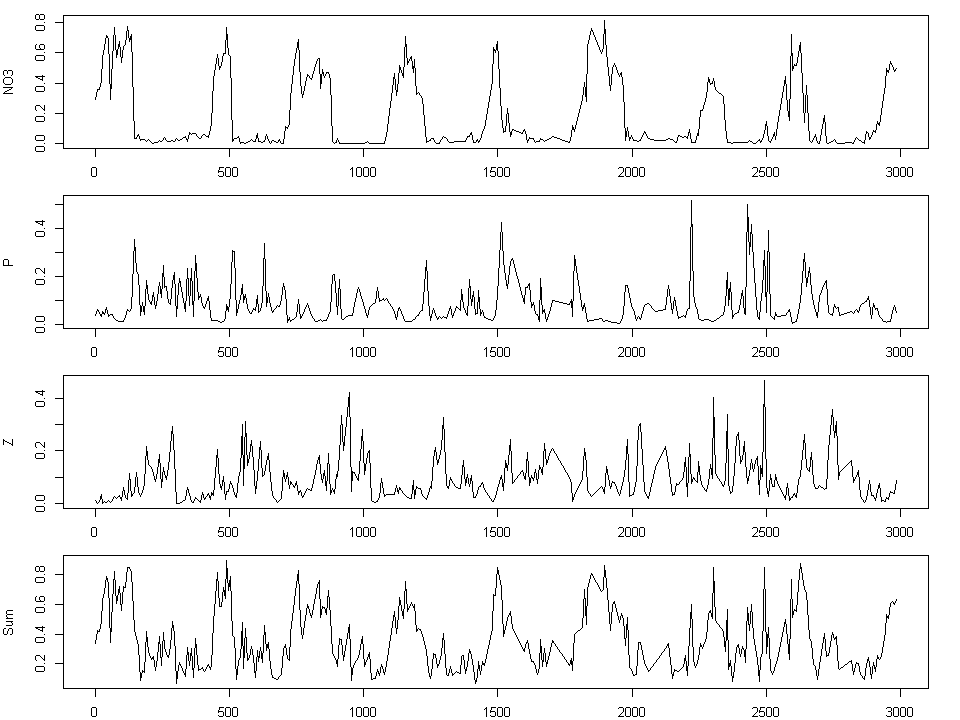

In [40]:
options(repr.plot.width=8, repr.plot.height=6)
par(mfrow=c(4,1),mar=c(2,4,1,2))
plot(data[,1],data[,2],type='l',ylab='NO3')
plot(data[,1],data[,3],type='l',ylab='P')
plot(data[,1],data[,4],type='l',ylab='Z')
plot(data[,1],rowSums(data[,2:4]),type='l',ylab='Sum')

### challenges for fitting data:
 * high noise level
 * no conservation of mass while NPZ model conserves mass

## 2. Modifications to the NPZ model

allow influx and loss of N in the model:
 * introduce a background concentration for each variable and allow mixing with that background concentration
 * have a winter period for each year with stronger mixing and different background concentrations
 * estimate start and duration of winter period for each year (initial guess is based on data)
 * estimate background concentrations for winter and regular period (same for each year)
 
 

In [28]:
stan_code = "functions {
    real[] npz(real   t,     // time
              real[] x,     // state
              real[] theta, // parameters
              real[] x_r,   // real-valued input data (empty)
              int[]  x_i) { // integer-valued input data (empty)
    /*
    guide to theta:
    theta[1]:  vmax        maximum growth rate in Michaelis Menten formulation
    theta[2]:  nuthalfsat  nutrient half saturation in Michaelis Menten formulation
    theta[3]:  graz        zooplankton grazing rate
    theta[4]:  mort_p      phytoplankton mortality rate
    theta[5]:  mort_z      zooplankton mortality rate
    theta[6]:  bgconc_n1   N background concentration regular
    theta[7]:  bgconc_n2   N background concentration winter
    theta[8]:  bgconc_p1   P background concentration regular
    theta[9]:  bgconc_p2   P background concentration winter
    theta[10]: bgconc_z1   Z background concentration regular
    theta[11]: bgconc_z2   Z background concentration winter
    theta[12]: mix1        mixing strength regular
    theta[13]: mix2        mixing strength winter
    theta[14]:             start time of first winter
    theta[15]:             stop time of first winter
    theta[16]:             start time of second winter
    theta[17]:             stop time of second winter
    ...                    number of winters is set to nyears
    */

    real n = fmax(0.0, x[1]);
    real p = fmax(0.0, x[2]);
    real z = fmax(0.0, x[3]);

    real growth  = theta[1]*n/(theta[2]+n) * p; // nutrient-dependent growth
    real grazing = theta[3]*p*z;                // grazing
    real ploss   = theta[4]*p;                  // linear phytoplankton mortality
    real zloss   = theta[5]*z*z;                // quadratic zooplankton mortality

    // N,P,Z gain or loss terms due to mixing/exchange with background
    real exch_n;
    real exch_p;
    real exch_z;

    int i = 14;
    while (i <= size(theta) && t>=theta[i]){
        i += 1;
    }
    if ((i-13)%2 == 1){
        // regular (non-winter) time
        exch_n = theta[12]*(theta[6]-n);
        exch_p = theta[12]*(theta[8]-p);
        exch_z = theta[12]*(theta[10]-z);
    } else {
        // winter time
        exch_n = theta[13]*(theta[7]-n);
        exch_p = theta[13]*(theta[9]-p);
        exch_z = theta[13]*(theta[11]-z);
    }
    return {-growth+ploss+zloss+exch_n,growth-grazing-ploss+exch_p,grazing-zloss+exch_z};
    }
}
data {
    int<lower=0> nobs;               // number of timesteps with observations
    real<lower=0> tobs[nobs];        // obs times
    int<lower=0> nobsvar;            // number of observed variables
    int<lower=0> iobsvar[nobsvar];   // index of observed variable (N=1, P=2, Z=3)
    real<lower=0> obs[nobs,nobsvar]; // observed variable at measurement times
    int<lower=0> nyears;             // number of years (number of winters to add to the model)
}
transformed data {
    real wintermixstart_guess[nyears];
    real wintermixduration_guess[nyears];
    {
        int start = 0;
        int iyear = 1;
        real thresh = 0.25;
        for (it in 1:nobs){
            if (start == 0 && obs[it,1] >= thresh){
                start = 1;
                wintermixstart_guess[iyear] = tobs[it];
            } else if (start == 1 && obs[it,1] < thresh && obs[it+1,1] < thresh){
                start = 0;
                wintermixduration_guess[iyear] = tobs[it] - wintermixstart_guess[iyear];
                wintermixstart_guess[iyear] -= 365.0*(iyear-1);
                iyear += 1;
                if (iyear > nyears){
                    break;
                }
            }
        }
    }
    // will be printed once by every chain
}
parameters {
    real<lower=0> vmax;        // maximum growth rate in Michaelis Menten formulation
    real<lower=0> nuthalfsat;  // nutrient half saturation in Michaelis Menten formulation
    real<lower=0> graz;        // zooplankton grazing rate
    real<lower=0> mort_p;      // phytoplankton mortality rate
    real<lower=0> mort_z;      // zooplankton mortality rate
    real<lower=0> bgconc_n1;   // N background concentration regular
    real<lower=0> bgconc_n2;   // N background concentration winter
    real<lower=0> bgconc_p1;   // P background concentration regular
    real<lower=0> bgconc_p2;   // P background concentration winter
    real<lower=0> bgconc_z1;   // Z background concentration regular
    real<lower=0> bgconc_z2;   // Z background concentration winter
    real<lower=0> mix1;        // mixing strength regular
    real<lower=0> mix2;        // mixing strength winter
    real<lower=-100.0,upper=200.0> wintermixstart[nyears]; // start of winter mixing, restricted to broad winter period
    real<lower=0> wintermixduration[nyears]; // duration of winter mixing

    real<lower=1E-15> sigma[nobsvar]; // observation error standard deviations
    real<lower=0> x0[3];              // initial conditions
}
transformed parameters {
    real theta[13+2*nyears];
    real x[nobs,3];

    theta[1] = vmax;
    theta[2] = nuthalfsat;
    theta[3] = graz;
    theta[4] = mort_p;
    theta[5] = mort_z;
    theta[6] = bgconc_n1;
    theta[7] = bgconc_n2;
    theta[8] = bgconc_p1;
    theta[9] = bgconc_p2;
    theta[10] = bgconc_z1;
    theta[11] = bgconc_z2;
    theta[12] = mix1;
    theta[13] = mix2;
    for (iyear in 1:nyears){
        theta[13+2*iyear-1] = wintermixstart[iyear] + (iyear-1)*365.0;
        theta[13+2*iyear] = theta[13+2*iyear-1] + wintermixduration[iyear];
    }
    x = integrate_ode_rk45(npz, x0, -1, tobs, theta,
                           rep_array(0.0, 0), rep_array(0, 0),
                           1e-5, 1e-4, 2e3*nyears);
}
model {

    x0[1] ~ normal(0.3, 0.1);         // prior on N initial conditions
    x0[2] ~ normal(0.1, 0.1);         // prior on P initial conditions
    x0[3] ~ normal(0.1, 0.1);         // prior on Z initial conditions

    sigma      ~ exponential(1.0);

    // priors for parameters
    vmax       ~ normal(0.15, 0.03);
    nuthalfsat ~ normal(0.17, 0.04);
    graz       ~ normal(0.15, 0.04);
    mort_p     ~ normal(0.02, 0.01);
    mort_z     ~ normal(0.02, 0.005);
    bgconc_n1  ~ normal(0.01, 0.001); // (regular) 
    bgconc_n2  ~ normal(0.66, 0.08);  // (winter) 
    bgconc_p1  ~ normal(0.11, 0.01);  // (regular)
    bgconc_p2  ~ normal(0.05, 0.005); // (winter)
    bgconc_z1  ~ normal(0.09, 0.01);  // (regular)
    bgconc_z2  ~ normal(0.05, 0.03);  // (winter)
    mix1       ~ normal(0.01, 0.03);  // (regular)
    mix2       ~ normal(0.19, 0.02);  // (winter)
    for (iyear in 1:nyears){
        wintermixstart[iyear]    ~ normal(wintermixstart_guess[iyear], 10.0);
        wintermixduration[iyear] ~ normal(wintermixduration_guess[iyear], 10.0);
    }
    // no fitting of data yet
}"

## 3. Sampling from the prior

Because we are not yet fitting data in the model, the Stan output are samples from the prior model solution.

In [80]:
mod <- stan_model(model_code=stan_code)

In [42]:
nyears <- 2
index  <- data[,1] <= nyears*365 

stan_data <- list(nobs = sum(index),
             tobs = data[index,1],
             nobsvar = 3,
             iobsvar = c(1,2,3),
             obs = data[index,c(2,3,4)],
             nyears=nyears)

In [44]:
mcmc <- sampling(mod, data=stan_data, iter=1000)

In [45]:
mcmc

Inference for Stan model: c748817729cd535ac1b880c4e30a2435.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                       mean se_mean    sd   2.5%    25%    50%    75%  97.5%
vmax                   0.15    0.00  0.03   0.09   0.13   0.15   0.17   0.21
nuthalfsat             0.17    0.00  0.04   0.10   0.14   0.17   0.19   0.25
graz                   0.15    0.00  0.04   0.08   0.12   0.15   0.18   0.23
mort_p                 0.02    0.00  0.01   0.00   0.01   0.02   0.03   0.04
mort_z                 0.02    0.00  0.01   0.01   0.02   0.02   0.02   0.03
bgconc_n1              0.01    0.00  0.00   0.01   0.01   0.01   0.01   0.01
bgconc_n2              0.66    0.00  0.08   0.50   0.61   0.66   0.72   0.81
bgconc_p1              0.11    0.00  0.01   0.09   0.10   0.11   0.12   0.13
bgconc_p2              0.05    0.00  0.00   0.04   0.05   0.05   0.05   0.06
bgconc_z1              0.09    0.00  0.01   0.07   0.0

In [48]:
prior <- extract(mcmc)

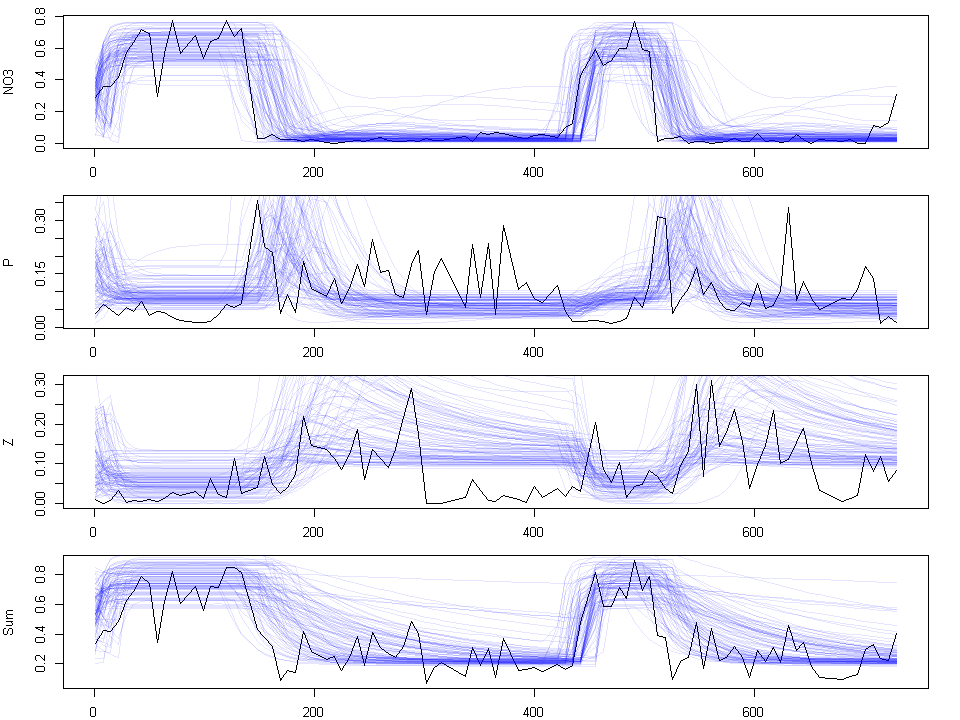

In [59]:
options(repr.plot.width=8, repr.plot.height=6)
par(mfrow=c(4,1),mar=c(2,4,1,2))

index_prior <- sample(1:nrow(prior$x),100)

t <- data[index,1]

plot(data[index,1],data[index,2],type='l',ylab='NO3')
    for(i in 1:length(index_prior)) lines(t,prior$x[index_prior[i],,1],col=adjustcolor('blue',alpha.f=0.1))
plot(data[index,1],data[index,3],type='l',ylab='P')
    for(i in 1:length(index_prior)) lines(t,prior$x[index_prior[i],,2],col=adjustcolor('blue',alpha.f=0.1))
plot(data[index,1],data[index,4],type='l',ylab='Z')
    for(i in 1:length(index_prior)) lines(t,prior$x[index_prior[i],,3],col=adjustcolor('blue',alpha.f=0.1))
plot(data[index,1],rowSums(data[index,2:4]),type='l',ylab='Sum')
    for(i in 1:length(index_prior)) lines(t,prior$x[index_prior[i],,1] +
                                            prior$x[index_prior[i],,2] +
                                            prior$x[index_prior[i],,3],col=adjustcolor('blue',alpha.f=0.1))




## 4. Reparameterizing the model and fitting data

Normally we would use a statement like 
```
for(i in 1:nobsvar){
    for (iobs in 1:nobs){
        obs[iobs,i] ~ normal(x[iobs,iobsvar[i]], sigma[i]);
    }
}
```
in Stan's model block to fit the data. When formulated this way, Stan can have trouble sampling from the posterior distribution, for example when `sigma[i]` changes greatly for different values of `x[iobs,iobsvar[i]]`.

Here it helps *a lot* (decrease in runtime by 1-2 orders of magnitude) to reparameterize the model:
```
for(i in 1:nobsvar){
    for (iobs in 1:nobs){
        obs_normalized = (obs[iobs,i]-x[iobs,iobsvar[i]])/sigma[i];
        obs_normalized ~ std_normal();
    }
}
```

For more information, see the corresponding section in the [Stan user guide](https://mc-stan.org/docs/stan-users-guide/reparameterization-section.html).

In [82]:
stan_code_reparam = "functions {
    real[] npz(real   t,     // time
              real[] x,     // state
              real[] theta, // parameters
              real[] x_r,   // real-valued input data (empty)
              int[]  x_i) { // integer-valued input data (empty)
    /*
    guide to theta:
    theta[1]:  vmax        maximum growth rate in Michaelis Menten formulation
    theta[2]:  nuthalfsat  nutrient half saturation in Michaelis Menten formulation
    theta[3]:  graz        zooplankton grazing rate
    theta[4]:  mort_p      phytoplankton mortality rate
    theta[5]:  mort_z      zooplankton mortality rate
    theta[6]:  bgconc_n1   N background concentration regular
    theta[7]:  bgconc_n2   N background concentration winter
    theta[8]:  bgconc_p1   P background concentration regular
    theta[9]:  bgconc_p2   P background concentration winter
    theta[10]: bgconc_z1   Z background concentration regular
    theta[11]: bgconc_z2   Z background concentration winter
    theta[12]: mix1        mixing strength regular
    theta[13]: mix2        mixing strength winter
    theta[14]:             start time of first winter
    theta[15]:             stop time of first winter
    theta[16]:             start time of second winter
    theta[17]:             stop time of second winter
    ...                    number of winters is set to nyears
    */

    real n = fmax(0.0, x[1]);
    real p = fmax(0.0, x[2]);
    real z = fmax(0.0, x[3]);

    real growth  = theta[1]*n/(theta[2]+n) * p; // nutrient-dependent growth
    real grazing = theta[3]*p*z;                // grazing
    real ploss   = theta[4]*p;                  // linear phytoplankton mortality
    real zloss   = theta[5]*z*z;                // quadratic zooplankton mortality

    // N,P,Z gain or loss terms due to mixing/exchange with background
    real exch_n;
    real exch_p;
    real exch_z;

    int i = 14;
    while (i <= size(theta) && t>=theta[i]){
        i += 1;
    }
    if ((i-13)%2 == 1){
        // regular (non-winter) time
        exch_n = theta[12]*(theta[6]-n);
        exch_p = theta[12]*(theta[8]-p);
        exch_z = theta[12]*(theta[10]-z);
    } else {
        // winter time
        exch_n = theta[13]*(theta[7]-n);
        exch_p = theta[13]*(theta[9]-p);
        exch_z = theta[13]*(theta[11]-z);
    }
    return {-growth+ploss+zloss+exch_n,growth-grazing-ploss+exch_p,grazing-zloss+exch_z};
    }
}
data {
    int<lower=0> nobs;               // number of timesteps with observations
    real<lower=0> tobs[nobs];        // obs times
    int<lower=0> nobsvar;            // number of observed variables
    int<lower=0> iobsvar[nobsvar];   // index of observed variable (N=1, P=2, Z=3)
    real<lower=0> obs[nobs,nobsvar]; // observed variable at measurement times
    int<lower=0> nyears;             // number of years (number of winters to add to the model)
}
transformed data {
    real wintermixstart_guess[nyears];
    real wintermixduration_guess[nyears];
    {
        int start = 0;
        int iyear = 1;
        real thresh = 0.25;
        for (it in 1:nobs){
            if (start == 0 && obs[it,1] >= thresh){
                start = 1;
                wintermixstart_guess[iyear] = tobs[it];
            } else if (start == 1 && obs[it,1] < thresh && obs[it+1,1] < thresh){
                start = 0;
                wintermixduration_guess[iyear] = tobs[it] - wintermixstart_guess[iyear];
                wintermixstart_guess[iyear] -= 365.0*(iyear-1);
                iyear += 1;
                if (iyear > nyears){
                    break;
                }
            }
        }
    }
    // will be printed once by every chain
}
parameters {
    real<lower=0> vmax;        // maximum growth rate in Michaelis Menten formulation
    real<lower=0> nuthalfsat;  // nutrient half saturation in Michaelis Menten formulation
    real<lower=0> graz;        // zooplankton grazing rate
    real<lower=0> mort_p;      // phytoplankton mortality rate
    real<lower=0> mort_z;      // zooplankton mortality rate
    real<lower=0> bgconc_n1;   // N background concentration regular
    real<lower=0> bgconc_n2;   // N background concentration winter
    real<lower=0> bgconc_p1;   // P background concentration regular
    real<lower=0> bgconc_p2;   // P background concentration winter
    real<lower=0> bgconc_z1;   // Z background concentration regular
    real<lower=0> bgconc_z2;   // Z background concentration winter
    real<lower=0> mix1;        // mixing strength regular
    real<lower=0> mix2;        // mixing strength winter
    real<lower=-100.0,upper=200.0> wintermixstart[nyears]; // start of winter mixing, restricted to broad winter period
    real<lower=0> wintermixduration[nyears]; // duration of winter mixing

    real<lower=1E-15> sigma[nobsvar]; // observation error standard deviations
    real<lower=0> x0[3];              // initial conditions
}
transformed parameters {
    real theta[13+2*nyears];
    real x[nobs,3];

    theta[1] = vmax;
    theta[2] = nuthalfsat;
    theta[3] = graz;
    theta[4] = mort_p;
    theta[5] = mort_z;
    theta[6] = bgconc_n1;
    theta[7] = bgconc_n2;
    theta[8] = bgconc_p1;
    theta[9] = bgconc_p2;
    theta[10] = bgconc_z1;
    theta[11] = bgconc_z2;
    theta[12] = mix1;
    theta[13] = mix2;
    for (iyear in 1:nyears){
        theta[13+2*iyear-1] = wintermixstart[iyear] + (iyear-1)*365.0;
        theta[13+2*iyear] = theta[13+2*iyear-1] + wintermixduration[iyear];
    }
    x = integrate_ode_rk45(npz, x0, -1, tobs, theta,
                           rep_array(0.0, 0), rep_array(0, 0),
                           1e-5, 1e-4, 2e3*nyears);
}
model {
    real obs_normalized;

    x0[1] ~ normal(0.3, 0.1);         // prior on N initial conditions
    x0[2] ~ normal(0.1, 0.1);         // prior on P initial conditions
    x0[3] ~ normal(0.1, 0.1);         // prior on Z initial conditions

    sigma ~ exponential(1.0);

    // priors for parameters
    vmax       ~ normal(0.15, 0.03);
    nuthalfsat ~ normal(0.17, 0.04);
    graz       ~ normal(0.15, 0.04);
    mort_p     ~ normal(0.02, 0.01);
    mort_z     ~ normal(0.02, 0.005);
    bgconc_n1  ~ normal(0.01, 0.001); // (regular) 
    bgconc_n2  ~ normal(0.66, 0.08);  // (winter) 
    bgconc_p1  ~ normal(0.11, 0.01);  // (regular)
    bgconc_p2  ~ normal(0.05, 0.005); // (winter)
    bgconc_z1  ~ normal(0.09, 0.01);  // (regular)
    bgconc_z2  ~ normal(0.05, 0.03); // (winter)
    mix1       ~ normal(0.01, 0.03); // (regular)
    mix2       ~ normal(0.19, 0.02);  // (winter)
    for (iyear in 1:nyears){
        wintermixstart[iyear]    ~ normal(wintermixstart_guess[iyear], 10.0);
        wintermixduration[iyear] ~ normal(wintermixduration_guess[iyear], 10.0);
    }
    // fitting the observations
    for(i in 1:nobsvar){
        for (iobs in 1:nobs){
            obs_normalized = (obs[iobs,i]-x[iobs,iobsvar[i]])/sigma[i];
            obs_normalized ~ std_normal();
        }
    }
}"

In [84]:
mod_reparam <- stan_model(model_code=stan_code_reparam,open_progress=TRUE)

In [86]:
mcmc_reparam <- sampling(mod_reparam,data=stan_data,open_progress=TRUE)

In [87]:
mcmc_reparam

Inference for Stan model: f008f0370eabca18980af2b955d860f6.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                       mean se_mean    sd   2.5%    25%    50%    75%  97.5%
vmax                   0.15    0.00  0.03   0.09   0.13   0.15   0.17   0.21
nuthalfsat             0.17    0.00  0.04   0.09   0.15   0.17   0.20   0.25
graz                   0.15    0.00  0.04   0.07   0.12   0.15   0.18   0.23
mort_p                 0.02    0.00  0.01   0.00   0.01   0.02   0.03   0.04
mort_z                 0.02    0.00  0.00   0.01   0.02   0.02   0.02   0.03
bgconc_n1              0.01    0.00  0.00   0.01   0.01   0.01   0.01   0.01
bgconc_n2              0.65    0.00  0.08   0.50   0.60   0.65   0.70   0.80
bgconc_p1              0.11    0.00  0.01   0.09   0.10   0.11   0.12   0.13
bgconc_p2              0.05    0.00  0.00   0.04   0.05   0.05   0.05   0.06
bgconc_z1              0.09    0.00  0.01   0.07   0

In [89]:
post_reparam <- extract(mcmc_reparam)

In [106]:
q_n <- apply(post_reparam$x[,,1],2,function(x) quantile(x,probs=c(0.025,0.25,0.5,0.75,0.975)))
q_p <- apply(post_reparam$x[,,2],2,function(x) quantile(x,probs=c(0.025,0.25,0.5,0.75,0.975)))
q_z <- apply(post_reparam$x[,,3],2,function(x) quantile(x,probs=c(0.025,0.25,0.5,0.75,0.975)))

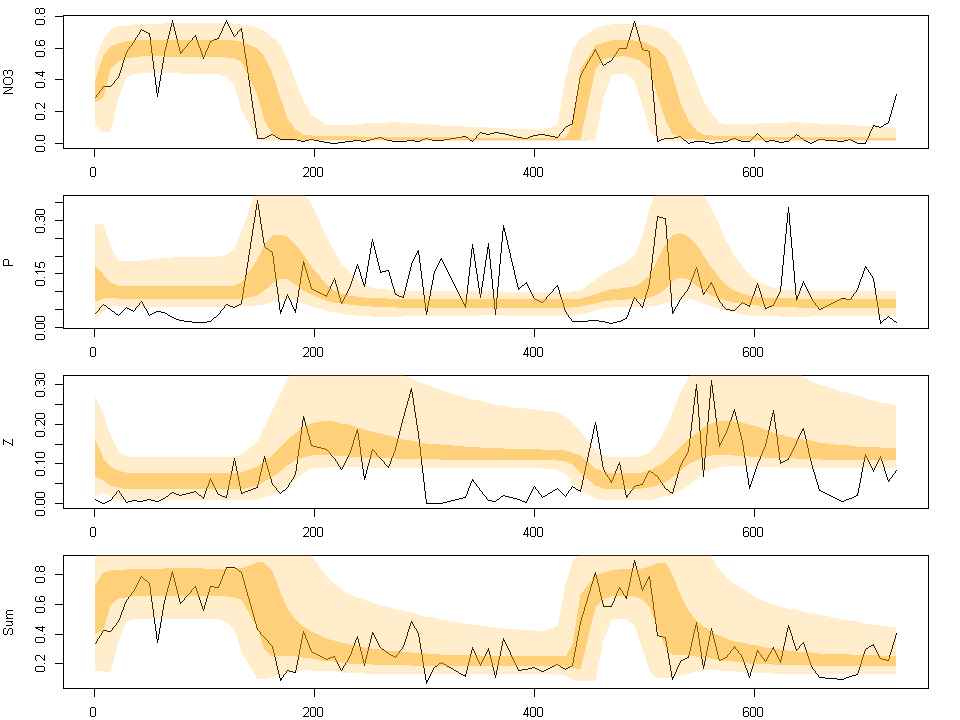

In [112]:
options(repr.plot.width=8, repr.plot.height=6)
par(mfrow=c(4,1),mar=c(2,4,1,2))

plot(data[index,1],data[index,2],type='l',ylab='NO3')
  polygon(x=c(data[index,1],rev(data[index,1])),y=c(q_n[1,],q_n[5,ncol(q_n):1]),col=adjustcolor('orange',alpha.f=0.2),border=FALSE)
  polygon(x=c(data[index,1],rev(data[index,1])),y=c(q_n[2,],q_n[4,ncol(q_n):1]),col=adjustcolor('orange',alpha.f=0.4),border=FALSE)
plot(data[index,1],data[index,3],type='l',ylab='P')
  polygon(x=c(data[index,1],rev(data[index,1])),y=c(q_p[1,],q_p[5,ncol(q_p):1]),col=adjustcolor('orange',alpha.f=0.2),border=FALSE)
  polygon(x=c(data[index,1],rev(data[index,1])),y=c(q_p[2,],q_p[4,ncol(q_p):1]),col=adjustcolor('orange',alpha.f=0.4),border=FALSE)
plot(data[index,1],data[index,4],type='l',ylab='Z')
  polygon(x=c(data[index,1],rev(data[index,1])),y=c(q_z[1,],q_z[5,ncol(q_z):1]),col=adjustcolor('orange',alpha.f=0.2),border=FALSE)
  polygon(x=c(data[index,1],rev(data[index,1])),y=c(q_z[2,],q_z[4,ncol(q_z):1]),col=adjustcolor('orange',alpha.f=0.4),border=FALSE)
plot(data[index,1],rowSums(data[index,2:4]),type='l',ylab='Sum')
  polygon(x=c(data[index,1],rev(data[index,1])),y=c(q_n[1,]+q_p[1,]+q_z[1,],
                                                    q_n[5,ncol(q_n):1]+q_p[5,ncol(q_p):1]+q_z[5,ncol(q_n):1]),col=adjustcolor('orange',alpha.f=0.2),border=FALSE)
  polygon(x=c(data[index,1],rev(data[index,1])),y=c(q_n[2,]+q_p[2,]+q_z[2,],
                                                    q_n[4,ncol(q_n):1]+q_p[4,ncol(q_p):1]+q_z[4,ncol(q_n):1]),col=adjustcolor('orange',alpha.f=0.4),border=FALSE)
